## **Welcome to StereoMM Analysis**

StereoMM is a graph fusion model that can integrate gene expression, histological images, and spatial location. And the information interaction within modalities is strengthened by introducing an attention mechanism.

We provide two methods to run the program. 

Method 1: Run from command line

Method 2: Run step by step in jupyter-notebook

# Method 1: Run from command line

2 steps to run StereoMM

Step 1: **Extract image features** using neural networks.

Step 2: **Fusion** of image and transcriptome information based on spatial neighbor relationships.


In [17]:
import os
os.getcwd()

'/data/work/stereomm'

In [2]:
# view dataset directory
!ls /data/work/StereoMMv1
#!cd StereoMMv1

example      models.py	    process_img.py	torch_pths	utils.py
__init__.py  output	    process_img_raw.py	trainer.py
__main__.py  print_cuda.py  __pycache__		tutorial.ipynb


In [1]:
# Start your analytical journey
!python process_img.py -a example/adata.h5ad -i example/image.tif -o example/image_out -b 100 -c 150 
!python __main.py__ --rna_data example/adata.h5ad --image_data example/image_out/img_feat.pkl -o example/real_test_nn --epochs 100 --lr 0.0001 --radiu_cutoff 100 --hidden_dims 2048 256 --latent_dim 100 --docoder_type GCN --opt adam --dim_reduction_method high_var --scale zscore --num_head 1 --decoder --brief_att

cuda:0
Namespace(bin_size=100, crop_size=150, image='example/image.tif', input='example/adata.h5ad', num_cluster=10, output='example/image_out', slide_gem=False) 

number of GPUs： 1
The GPU index currently in use： 0
CUDA available, using NVIDIA A100-SXM4-80GB.
The image tile has been completed. example/image_out/100_crop_150_label.txt, read it directly
The image feature extract has been completed. example/image_out/img_feat.pkl, read it directly
Clustering H&E image feature at number of clusters: 10
Resolution: (0.1, 1.2, 0.65), Unique Clusters: 10
Final Resolution: 0.65
Figure(549x600)
Namespace(att_mode='cross', brief_att=True, customize_decoder=True, dec=False, dim_reduction_method='high_var', epochs=100, feat_pca=False, gnn_type='GCN', hidden_dims=[2048, 256], image_data='example/image_out/img_feat.pkl', img_weight=1, knn=None, latent_dim=100, lr=0.0001, n_cluster=10, num_heads=1, opt='adam', output='example/real_test_nn', purning_knn=False, radiu_cutoff=100, rna_data='example/adat

# Method 2: Run step by step in jupyter-notebook

Basic Settings

In [19]:
import os
bin_size = 100
crop_size = 150
output='example/image_out'
name = str(bin_size)+'_crop_',str(crop_size)
name = "".join(name)
label_txt_file=str(name+'_label.txt')
adata_file=str(name+'_adata.h5ad')
tile_path = os.path.join(output,name)

## Step 1: **Extract image features** using neural networks.

In [20]:
from process_img import *
from utils import *
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

cuda:0


Read in H&E images and transcriptome data

In [22]:
image_path = 'example/image.tif'
rna_path = 'example/adata.h5ad'

# show the image 
image = Image.open(image_path)
print(type(image), image.size)

rna_adata = sc.read_h5ad(rna_path)
rna_adata = add_img2adata(image,rna_adata,bin_size = bin_size,library_id = "cancer",spatial_key = "spatial")

<class 'PIL.TiffImagePlugin.TiffImageFile'> (22100, 23986)


Image tilling and feature extraction

In [23]:
# H&E image tilling
mkdir(tile_path)
rna_adata = image_crop(image,rna_adata,save_path=tile_path,crop_size=crop_size,verbose=False)
# plot_spatial_with_img(rna_adata,output,file='rna_spatial_with_img.png')
# save_data(rna_adata,output,label_txt_file=label_txt_file,adata_file=adata_file)
print('Patches saved')

# Feature extraction
feature_extractor,model_com = load_model()
print('The device where the model is located:',next(feature_extractor.parameters()).device)

label_txt_path = os.path.join(output,label_txt_file)
feat_outputs = extract_img_feat(label_txt_path,extractor=feature_extractor)
save_img_feat(feat_outputs,output,feat_file = 'img_feat.pkl')
print('Features saved')

Tiling image: 100%|██████████ [ time left: 00:00 ]


Patches saved


FileNotFoundError: [Errno 2] No such file or directory: '/hsfscqjf1/ST_CQ/P22Z10200N0618/luobingying/multimodal/scripts/torch_pths/resnet50-19c8e357.pth'

H&E image feature clustering

Clustering H&E image feature at number of clusters: 10
Final Resolution: 0.65


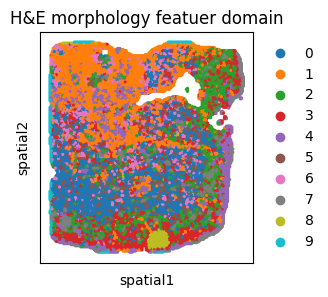

In [21]:
img_adata = sc.read('example/image_out/img_adata.h5ad')
#img_adata = generate_adata(feat_outputs.values,spatial=rna_adata.obsm['spatial'])

n_cluster = 10
print(f"Clustering H&E image feature at number of clusters: {n_cluster}")
resolution, img_adata = find_res_binary(img_adata, resolution_min=0.1, resolution_max=1.2, num_clusters=n_cluster,key_added='cluster')
print(f"Final Resolution: {resolution}")
plot_spatial(img_adata,output,title='H&E morphology featuer domain',group='leiden',set_scale =3)

# Step 2: **Fusion** of image and transcriptome information based on spatial neighbor relationships.

Basic Settings

In [24]:
import faulthandler
# 在import之后直接添加以下启用代码即可
faulthandler.enable()

import torch
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from utils import *
from models import *
from trainer import *
import warnings
warnings.filterwarnings("ignore")

set_seed(77)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

outdir = './example/real_test_nn/'

## DEMO data analysis displayDEMO data analysis display

### Load analysis data

In [5]:
toy_data = False
if toy_data == True:
    # Create number of nodes and feature dimensions
    num_nodes = 200
    num_features = 50

    # Randomly generate node features
    img_tensor = torch.randn(num_nodes, num_features).double().to(device)
    rna_tensor = torch.randn(num_nodes, num_features).double().to(device)

    # Randomly generate edge list
    edge_index = torch.randint(num_nodes, (2, num_nodes * 2))
    edge_index = edge_index.to(device)
    
    single_model_size=50
    hidden_size=[32,16] 
    latent_size=10 

else:
    ###========== Preprocessing of each modal feature ==========###
    img_feat = pd.read_pickle('example/image_out/img_feat.pkl')
    rna_adata = sc.read_h5ad('example/adata.h5ad')

    ### Unimodal preprocessing
    rna_feat = extract_rna_feat(rna_adata,num_feat=2048,dim_reduction_method = 'high_var')
    rna_feat = scale_data(rna_feat,scaler='zscore')
    img_feat = scale_data(img_feat,scaler='zscore')
    
    
    rna_tensor = torch.from_numpy(np.array(rna_feat)).double().to(device)
    img_tensor = torch.from_numpy(np.array(img_feat)).double().to(device)

    ### knn graph calculation
    out_dir = 'output'
    makedir(out_dir)
    knn_df,id_cell_trans = cal_spatial_net(rna_adata,rad_cutoff=100,map_id=True)

    # graph pruning
    purning = False
    if purning == True:
        knn_df = purning_by_cluster(knn_df=knn_df,rna_data=rna_adata,img_data=img_feat,init_res=0.4)

    index_knn_df = index_knn(knn_df,id_cell_trans)
    index_knn_df  
    index_knn_df.iloc[:,0:2].to_csv(os.path.join(out_dir,'knn.txt'),index=False,sep=' ',header=False)

    ### knn data loading
    graph_file_path = "knn.txt"
    edgelist = load_graph_edgelist(os.path.join(out_dir,'knn.txt'))
    edge_index = np.array(edgelist).astype(int).T
    edge_index = to_undirected(torch.from_numpy(edge_index).to(torch.long))
    edge_index = edge_index.to(device)
    
    single_model_size=2048
    hidden_size=[512,128] 
    latent_size=50 

Calculating spatial location graph......
The graph contains 155733 edges, 31409 cells.
4.9582 neighbors per cell on average.


In [6]:
print('input image feature shape: %s. \ninput rna feature shape: %s.' % (img_tensor.shape,rna_tensor.shape))
# Check the data used for graph convolution
data_obj = Data(edge_index=edge_index, x=img_tensor)
data_obj.validate(raise_on_error=True)

input image feature shape: torch.Size([31409, 2048]). 
input rna feature shape: torch.Size([31409, 2048]).


True

### Model building

In [25]:
recon_node_feat = True
if recon_node_feat == True:
    decoder_hidden_size = hidden_size.copy()
    decoder_hidden_size.reverse()
    decoder_hidden_size.insert(0,latent_size)

    decoder = Decoder(output_size=single_model_size*2,hidden_sizes=decoder_hidden_size)
    fimodal = FinalModal(single_model_size, hidden_size, latent_size, num_heads=1, attn_mode='cross', decoder = decoder,brief_att = True)
    
else:
    fimodal = FinalModal(single_model_size, hidden_size, latent_size, num_heads=1, attn_mode='cross')#,brief_att = False

fimodal = fimodal.double().to(device)
print(fimodal)

Attention_module cross.
 number of heads in Attention_module: 1
FinalModal(
  (atten): Attention_module(
    (attention): Multi_CrossAttention(
      (linear_q): Linear(in_features=2048, out_features=256, bias=False)
      (linear_k): Linear(in_features=2048, out_features=256, bias=False)
      (linear_v): Linear(in_features=2048, out_features=256, bias=False)
      (linear_output): Linear(in_features=256, out_features=2048, bias=True)
    )
  )
  (vae): CustomVAE(
    (encoder): Encoder(
      (stack_net): ModuleList(
        (0): ModuleList(
          (0): GraphConvLayer(
            (conv): GCNConv(4096, 512)
          )
          (1): ActivateLayer(
            (activation_func): ReLU()
          )
        )
        (1): ModuleList(
          (0): GraphConvLayer(
            (conv): GCNConv(512, 128)
          )
          (1): ActivateLayer(
            (activation_func): ReLU()
          )
        )
      )
    )
    (fc_mean): GCNConv(128, 50)
    (fc_logvar): GCNConv(128, 50)
  

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(fimodal)
print("Number of trainable parameters: ", num_params)

def count_parameters(model):
    return sum(p.numel() for p in model.atten.parameters() if p.requires_grad)
num_params = count_parameters(fimodal)
print("Number of attention layer trainable parameters: ", num_params)

Number of trainable parameters:  6449252
Number of attention layer trainable parameters:  2099200


### Model training

In [27]:
trainer = train(img_tensor, rna_tensor, edge_index, fimodal, custom_decoder = False,n_epochs=10, opt='adam', lr=0.0001, weight_decay=0.0001, save_att=True, verbose=True)
if False :#True
    loss_values, img_emb, rna_emb, attention_weight = trainer.train_dec(init = "kmeans", n_cluster = 10, n_neighbors = 20, max_epochs = 100, update_interval = 10, tol = 1e-5, alpha = 0.9)
    flag = 'dec'
else:
    loss_values, img_emb, rna_emb, attention_weight = trainer.train_ae()
    flag = 'ae'
emb = trainer.predict()

tarining AE


Training model...: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it, loss: 12.8705]


In [28]:
print(img_emb.shape,rna_emb.shape)

torch.Size([31409, 2048]) torch.Size([31409, 2048])


[19.076364344635227, 18.225818003418436, 17.408744278524996, 16.652747497778712, 15.960029138407942, 15.26118277122764, 14.558875544530292, 13.9408178133704, 13.312502717431292, nan]


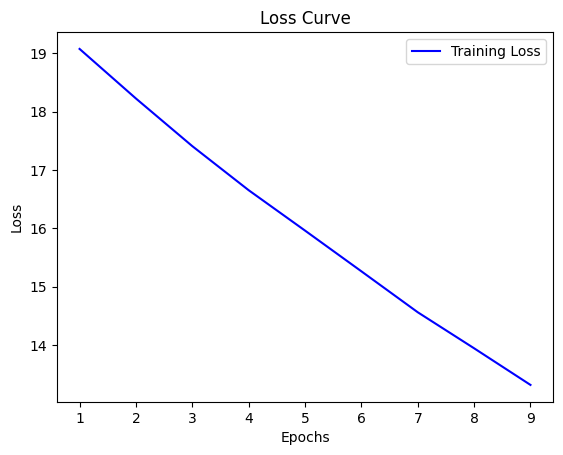

In [10]:
print(loss_values)
plot_loss_curve(loss_values,out_dir=outdir)

### 结果分析

Resolution: (0.1, 1.2, 0.65), Unique Clusters: 14
Resolution: (0.1, 0.65, 0.375), Unique Clusters: 9
Resolution: (0.375, 0.65, 0.5125), Unique Clusters: 12
Resolution: (0.375, 0.5125, 0.44375), Unique Clusters: 9
Resolution: (0.44375, 0.5125, 0.47812499999999997), Unique Clusters: 11
Resolution: (0.44375, 0.47812499999999997, 0.4609375), Unique Clusters: 11
Resolution: (0.44375, 0.4609375, 0.45234375), Unique Clusters: 9
Resolution: (0.45234375, 0.4609375, 0.456640625), Unique Clusters: 10
Final Resolution: 0.456640625


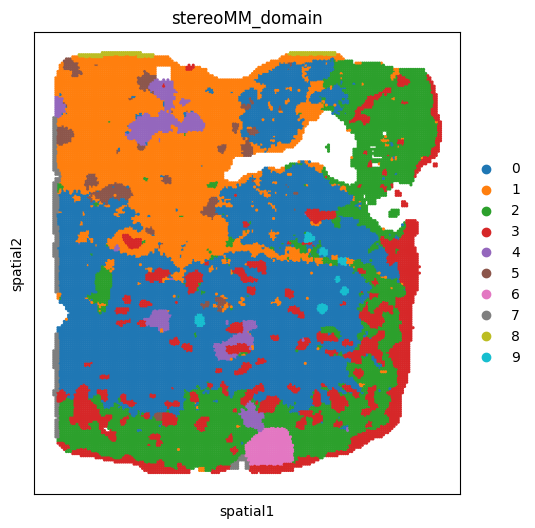

In [13]:
# Generate from previous results
# emb.index = rna_adata.obs.index
# emb.to_pickle(os.path.join(out_dir,'embedding.pkl'))
# emb.to_csv(os.path.join(out_dir,'embedding.csv'))
# stereomm_adata = generate_adata(emb , spatial=rna_adata.obsm['spatial'])

stereomm_adata = sc.read('./example/real_test_nn/emb_adata.h5ad')

n_cluster = 10
resolution, adata = find_res_binary(stereomm_adata, resolution_min=0.1, resolution_max=1.2, num_clusters=n_cluster)
print(f"Final Resolution: {resolution}")
plot_spatial(adata,out_dir,'stereoMM_domain')